In fastai part 1 we looked at how to categorize MNIST dataset.  In this tutorial, we will dive a bit deeper to see what happens under the hood.  First, we will take a deeper look at the MNIST dataset.

## Data Exploration

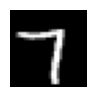

In [ ]:
# code from part 1
import torch
import random
from fastai.vision.all import *

# download the simple MNIST data set (not the full dataset yet, which we will do later)
path = untar_data(URLs.MNIST_SAMPLE)
train_path = path/'train'
img_files = list((train_path/'7').ls())
img = PILImage.create(img_files[0])
img.show();

In [25]:
print(f"Image mode is: {img.mode}")

Image mode is: RGB


MNIST images are grayscale (single channel).  When created by PILImage, they are converted to RGB, likely for model compatibility.  This is why as the print out shown above, the mode of the image is now RGB.  Grayscale image would have shown a "L" (1 channel), as opposed to RGB (3 channels).  If you want to keep the image as grayscale, you can use the following code:
```python
img = PILImage.create(img_files[0])
img.show();
print(f"Image mode is: {img.mode}")
```

In [26]:
arr = array(img)
print(arr.shape)

(28, 28, 3)


(28, 28, 3) is a 3D NumPy array of height, width, and channel.  It has a size of 28x28 pixels.  '3' means the RGB channels and they are likely have the same values as the image is grayscale.

In [27]:
print(np.unique(arr))

[  0   9  23  24  34  38  44  46  47  64  69  71  76  93  99 104 107 109
 111 115 128 137 138 139 145 146 149 151 154 161 168 174 176 180 184 185
 207 208 214 215 221 230 231 240 244 245 251 253 254 255]


`np.unique(arr)` gives a range of values showing that these pixel values span from 0 to 255.  '0' is black and '255' is white.  The values in between are shades of gray.

In [28]:
np.all(arr[:, :, 0] == arr[:, :, 1]) and np.all(arr[:, :, 1] == arr[:, :, 2])

np.True_

The code above checks if the pixel values are the same for all three channels.  Since the image is grayscale, the values are the same hence np.True

In [85]:
img_t = tensor(arr[:, :, 0])
print(img_t.shape)
df = pd.DataFrame(img_t)
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

torch.Size([28, 28])


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,64,145,161,221,254,138,0,0,0,0,0,0,0,0
8,0,0,76,214,230,231,180,138,138,139,138,214,230,231,251,253,253,254,253,137,0,0,0,0,0,0,0,0
9,0,0,76,146,230,245,253,253,253,254,253,253,253,230,230,154,104,254,253,137,0,0,0,0,0,0,0,0


In the code above:
`arr[:,:,0]` is a common way to index into a 3-dimensional NumPy array (or a similar array-like object, such as a PyTorchtensor or PIL image array). ':' means _all elements_ along that axis.  Thus arr[:,:,0] selects all rows (:), all columns (:), and channel 0 (e.g., the red channel in the RGB image, the entire channel would be something like (0,0,0)).

In [ ]:
# now compare the difference in shape between with or without selection of channel 0.
print(arr[:,:,0].shape)
print(arr[:,:,:].shape)

(28, 28)
(28, 28, 3)


In [ ]:
# Now let's take a look at the unique values in the array, 
print(np.unique(arr))

[  0   9  23  24  34  38  44  46  47  64  69  71  76  93  99 104 107 109
 111 115 128 137 138 139 145 146 149 151 154 161 168 174 176 180 184 185
 207 208 214 215 221 230 231 240 244 245 251 253 254 255]


These values represents the grayscale image of the digit 7 you see above.  Or how computer stores the image - with only numbers!  So the task of hand-writing recoginition of digits boils down to identify the similarity between the image and the reference digit images in numerical terms.  So we will go ahead and convert all images into numerical vectors, take the average value of 3s and 7s, and use the average vector as the representation of the digit.  This is called the _vector space model_. This will be the baseline of our model.  We then use this to predict the digit of a new image, and see if the new image is more similar to 3 or 7.  This is the simplest form (and the most intuitive) of machine learning.  A discriminate reader might notice that we have converted the NumPy array into a tensor (`img_t=tensor(arr[:,:,0])`).  This is a common practice in fastai.  Fastai is built on top of PyTorch, whose models are designed to work with torch.Tensor objects.  This means that all the layers, loss functions, and optimizers in PyTorch expect their inputs and outputs to be tensors.  Tensor supports automatic differentiation (autograd), meaning PyTorch can automatically compute graients for tensors during backpropagation, whilst their counterpart NumPy array can't.  One of the important characteristics of tensor is that it supports GPU acceleration, meaning that tensors can be moved to and operated on GPUs for faster computation (tensor.cuda()), while NumPy arrays are always on the CPU.

In [29]:
tensor(arr).permute(2,0,1).shape

torch.Size([3, 28, 28])

The code above converts the NumPy array to a PyTorch tensor and then permutes the dimensions.  The original shape is (28, 28, 3) and after permutation, it becomes (3, 28, 28).  This is the format that PyTorch expects for images: (channels, height, width).

## Baseline Images

**Stacking**
`torch.stack(seven_tensors)`: seven_tensors is a list of 2D tensors, where each tensor represents an image of digit "7".  Each tensor has a shape of [height, width] (28x28).
Stacking means that we combine all these individual 2D tensors into a single 3D tensor by adding a new dimension at the beginning.  The resutig tensor has a shape of [number_of_images, height, width].  The `.mean(0)` calculates the mean along dimension 0 (the first dimension), which is the "number_of_images" dimension.  This effectively averages all the "7" images pixel by pixel, resulting in a single 2D tensor that represents the average "7" image.

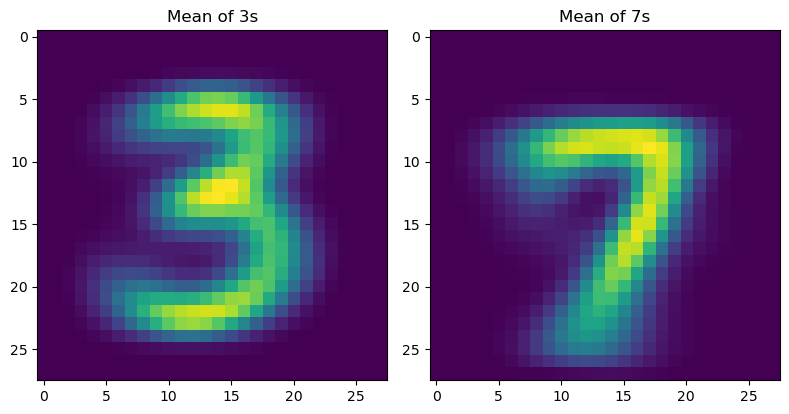

In [ ]:
# look at the 3 and 7 images
three_path = train_path/'3'
seven_path = train_path/'7'

three_tensors = [tensor(Image.open(o)) for o in three_path.ls()]
seven_tensors = [tensor(Image.open(o)) for o in seven_path.ls()]

# stack all the 3s and 7s
stacked_threes = torch.stack(three_tensors).float()/255
stacked_sevens = torch.stack(seven_tensors).float()/255

# calculate the mean of all 3s and 7s
mean3 = stacked_threes.mean(0)
mean7 = stacked_sevens.mean(0)

# show the mean images
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1) # (1, 2, 1) means that the subplot is 1 row, 2 columns, and this is the first plot (starting from upper left corner)
plt.imshow(mean3)
plt.title('Mean of 3s')
plt.subplot(1, 2, 2)
plt.imshow(mean7)
plt.title('Mean of 7s')
plt.tight_layout()

The code above calculates the mean of all 3s and 7s.  The mean image shows the average pixel values across all images of that digit.  This gives us a template of what a typical 3 and 7 look like.

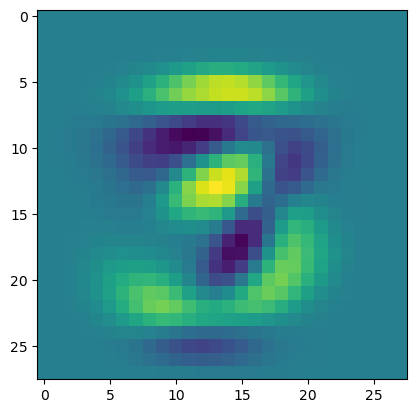

In [ ]:
# calculate the difference between the mean 3 and mean 7
diff = mean3 - mean7
plt.imshow(diff)

The difference image shows where the two digits differ the most.  Bright areas indicate where 3s have higher pixel values than 7s, and dark areas indicate where 7s have higher pixel values than 3s.

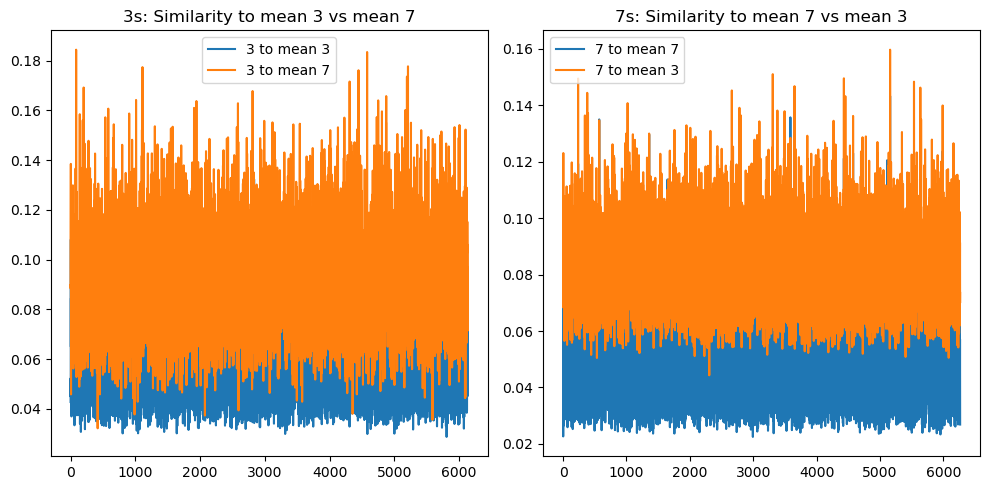

In [ ]:
# calculate the similarity between each 3 and the mean 3, and each 3 and the mean 7
three_similarity = [((t - mean3)**2).mean().item() for t in stacked_threes]
three_to_seven_similarity = [((t - mean7)**2).mean().item() for t in stacked_threes]

# calculate the similarity between each 7 and the mean 7, and each 7 and the mean 3
seven_similarity = [((t - mean7)**2).mean().item() for t in stacked_sevens]
seven_to_three_similarity = [((t - mean3)**2).mean().item() for t in stacked_sevens]

# plot the similarities
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(three_similarity, label='3 to mean 3')
plt.plot(three_to_seven_similarity, label='3 to mean 7')
plt.legend()
plt.title('3s: Similarity to mean 3 vs mean 7')

plt.subplot(1, 2, 2)
plt.plot(seven_similarity, label='7 to mean 7')
plt.plot(seven_to_three_similarity, label='7 to mean 3')
plt.legend()
plt.title('7s: Similarity to mean 7 vs mean 3')
plt.tight_layout()



**Similarity Calculation**
`((tensor(Image.open(o)).float() - seven_avg)**2).mean()` computes the similarity between a given image `o` and the average "7" image.  In essence, this is the _mean squared error (MES)_ between each "7" images and the average "7" image.  Lower MSE indicates higher similarity.  MSE is a common metric used to measure the similarity (or differences) between predicted value and actual value.  It says that we apply the square to the difference (which may be positive or negative), the apply the square root to take the effect of square away.  But in this process, we turn the differences to only positive values.

**Plot**
- The y-axis represents the MSE.
- The x-axis represents the index of the image in the dataset.
- This plot shows that each "3" image has a lower MSE with the average "3" than with the average "7".
- **Note** we didn't scale the y-axis in order to visualize the differences more clearly.

## Training a Neural Network on fullset of MNIST

Now that we've explored the MNIST dataset and understood its structure, let's train a neural network to classify the digits. We'll use the full MNIST dataset instead of just the sample we've been working with.

In [52]:
# Download the full MNIST dataset
path = untar_data(URLs.MNIST)
path

Path('/Users/zlu/.fastai/data/mnist_png')

In [53]:
# create a DataBlock for the MNIST dataset
mnist = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock), 
    get_items=get_image_files, 
    splitter=GrandparentSplitter(train_name='training', valid_name='testing'),
    get_y=parent_label,
    batch_tfms=Normalize()
)

### DataBlock
A fastai DataBlock is a high-level API abstraction for data processing, like a data pipeline.  It takes the raw dataset and prepare it to train machine learning models.  There is a a lot of logic underneath this process.  First you need to specify how to get the data (file path for example).  Then you need to specify how they should be labeled; what transformations to apply (e.g., resizing, augmentataion); how to split the data (training/validation) and finally what types of inputs/outputs are involved.  So our code snippet above defines:

1. `blocks=(ImageBlock(cls=PILImageBW), CategoryBlock)` specifies that inputs are black and white images (PILImageBW) and the outputs are categories (digits 0-9).
2. `get_items=get_image_files` gets all image files from our path.
3. `splitter=GrandparentSplitter(train_name='training', valid_name='testing')` splits the data based on the grandparent directory name. In the MNIST dataset, the structure is `path/training/digit/image.jpg` and `path/testing/digit/image.jpg`.
4. `get_y=parent_label` gets the label (digit) from the parent directory name.
5. `batch_tfms=Normalize()`: This normalizes our images to have zero mean and unit variance, which helps with training.

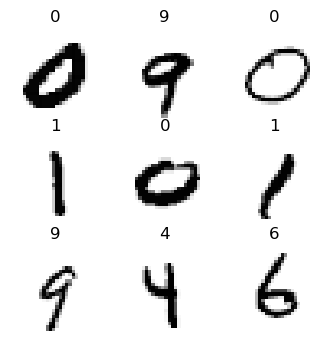

In [74]:
# create the DataLoaders
dls = mnist.dataloaders(path, bs=64) #bs is batch size

# show a random batch (sample) of images
dls.show_batch(max_n=9, figsize=(4,4))

Now let's create and train a convolutional neural network (CNN) for digit classification.  This model is designed specifically for single-channel grayscale images.  We will not get too deep into CNN for now.  We will have a separate tutorial dedicated to CNN.

In [59]:
# create a simple custom CNN model for MNIST
class MnistCNN(nn.Module):
    def __init__(self):
        super().__init__()
        # input: 1 channel (grayscale), Output: 16 feature maps
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        
        # input: 16 channels, Output: 32 feature maps
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        
        # input: 32 channels, Output: 64 feature maps
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2)
        
        # fully connected layers
        # after 3 pooling layers of factor 2, the 28x28 image is reduced to 3x3
        self.fc1 = nn.Linear(64 * 3 * 3, 128)
        self.relu4 = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)  # 10 classes for digits 0-9
    
    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.pool3(self.relu3(self.conv3(x)))
        
        # flatten the output for the fully connected layers
        x = x.view(x.size(0), -1)
        x = self.relu4(self.fc1(x))
        x = self.fc2(x)
        return x

# create a custom model
model = MnistCNN()

# create a learner with our custom CNN model
learn = Learner(dls, model, loss_func=nn.CrossEntropyLoss(), metrics=accuracy)

# print the model structure to understand it better
print("Model structure:")
print(learn.model)

Model structure:
MnistCNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=576, out_features=128, bias=True)
  (relu4): ReLU()
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [60]:
# train the model for 1 epochs
learn.fine_tune(1)

epoch,train_loss,valid_loss,accuracy,time
0,0.088422,0.065185,0.979500,00:34


epoch,train_loss,valid_loss,accuracy,time
0,0.030792,0.024418,0.991900,00:33


## Model Evaluation
Let's examine the model's performance on the **validation** set:

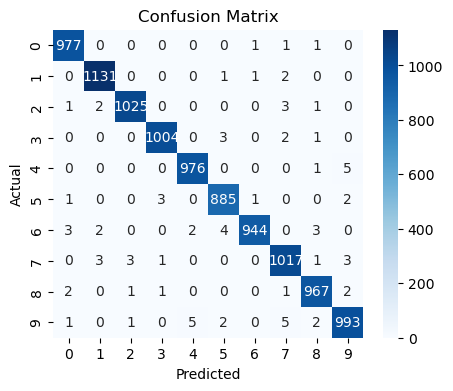

In [ ]:
# get predictions
preds, targets = learn.get_preds()
pred_classes = preds.argmax(dim=1)

# create confusion matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(targets, pred_classes)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## Making Predictions

Now let's use our trained model to make predictions on some test images:

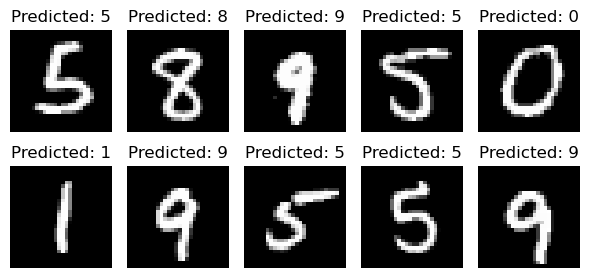

In [81]:
# get some test images
test_files = get_image_files(path/'testing')
# take 9 random sample images
random_test_files = random.sample(test_files, 10)

test_dl = learn.dls.test_dl(random_test_files)

# make predictions
preds, _ = learn.get_preds(dl=test_dl)
pred_classes = preds.argmax(dim=1)

# Display the images and predictions
fig, axes = plt.subplots(2, 5, figsize=(6, 3))
axes = axes.flatten()

for i, (img_file, pred) in enumerate(zip(random_test_files, pred_classes)):
    img = PILImage.create(img_file)
    axes[i].imshow(img, cmap='gray')
    axes[i].set_title(f"Predicted: {pred.item()}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

## Comparing with Our Template Matching Approach

Earlier, we used a template matching approach with MSE to distinguish between digits 3 and 7. Let's compare the performance of our neural network with that approach:

In [82]:
# get all test images of 3 and 7
test_3_files = get_image_files(path/'testing'/'3')
test_7_files = get_image_files(path/'testing'/'7')

# create a test dataset with only 3s and 7s
test_files_3_7 = test_3_files[:50] + test_7_files[:50]
test_dl_3_7 = learn.dls.test_dl(test_files_3_7)

# make predictions
preds, _ = learn.get_preds(dl=test_dl_3_7)
pred_classes = preds.argmax(dim=1)

# calculate accuracy for 3s and 7s
true_labels = torch.tensor([3] * 50 + [7] * 50)
correct = (pred_classes == true_labels).float().mean()
print(f"Neural Network Accuracy on 3s and 7s: {correct.item():.4f}")

Neural Network Accuracy on 3s and 7s: 0.9900


## Visualizing Feature Maps

Let's visualize what features our CNN is learning by examining the activations of the first convolutional layer:

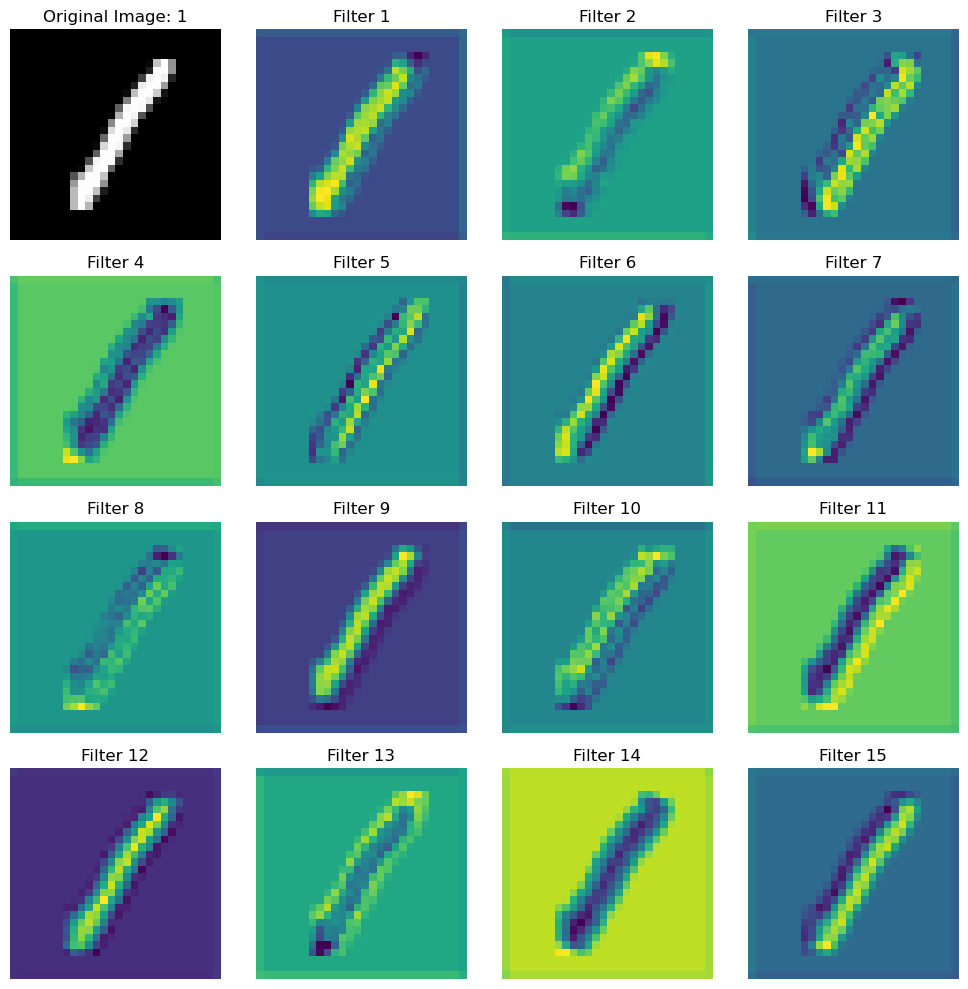

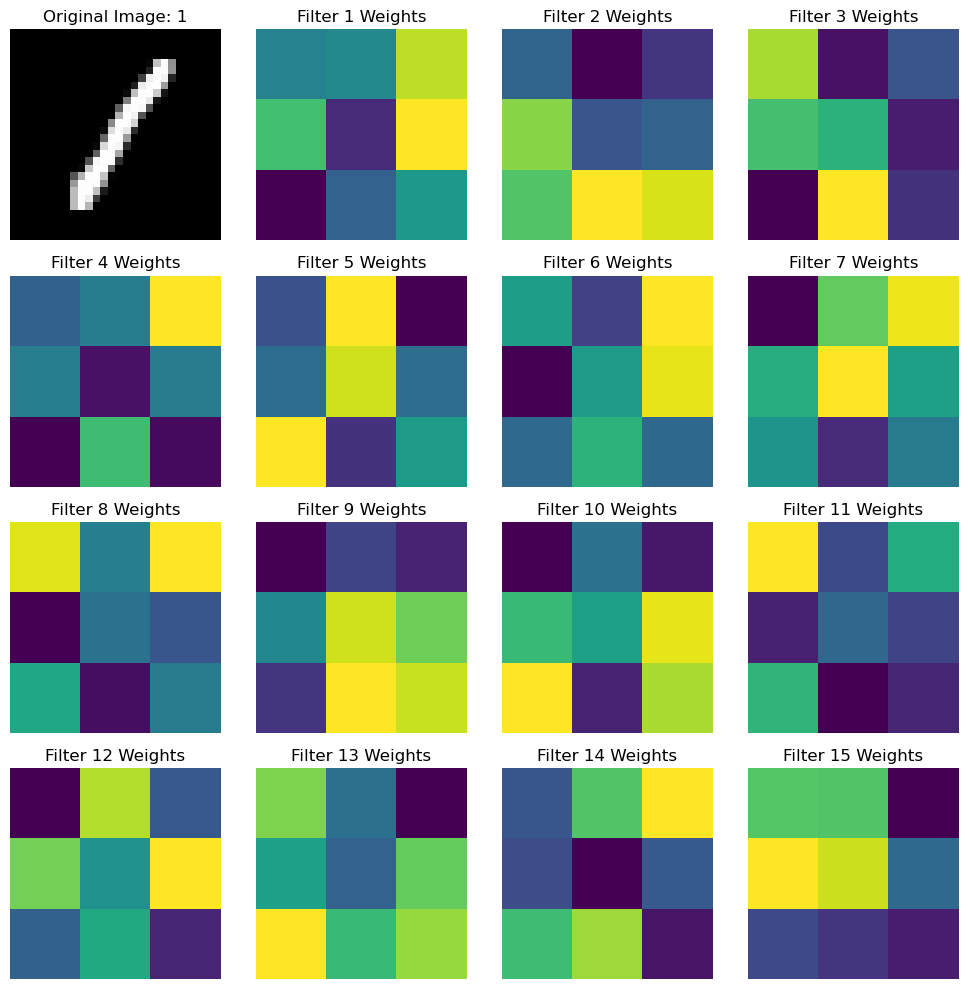

In [ ]:
# get a batch of images
x, y = dls.one_batch()

# get the first convolutional layer from our custom model
#gFor our custom MnistCNN model, we can directly access the conv1 attribute
conv1 = learn.model.conv1

# apply the first conv layer to get activations
with torch.no_grad():
    activations = conv1(x)

# visualize the activations for the first image
# our custom model has 16 filters in the first layer
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
axes = axes.flatten()

# show the original image
axes[0].imshow(x[0][0].cpu(), cmap='gray')
axes[0].set_title(f"Original Image: {y[0].item()}")
axes[0].axis('off')

# show the activation maps for the first 15 filters
for i in range(1, 16):
    axes[i].imshow(activations[0, i-1].detach().cpu(), cmap='viridis')
    axes[i].set_title(f"Filter {i}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

# also visualize the filter weights
weights = conv1.weight.data.cpu()
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
axes = axes.flatten()

# show the original image again
axes[0].imshow(x[0][0].cpu(), cmap='gray')
axes[0].set_title(f"Original Image: {y[0].item()}")
axes[0].axis('off')

# show the weights for the first 15 filters
for i in range(1, 16):
    # Each filter has only one input channel (grayscale)
    axes[i].imshow(weights[i-1, 0], cmap='viridis')
    axes[i].set_title(f"Filter {i} Weights")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

## Conclusion

In this notebook, we've explored the MNIST dataset in depth and trained a convolutional neural network to classify handwritten digits. We've seen how the model performs and visualized some of its internal representations.

Key takeaways:
1. Neural networks can achieve high accuracy on digit classification tasks.
2. The first layers of a CNN learn simple features like edges and textures.
3. The template matching approach we explored earlier is much simpler but less accurate than a full neural network.
4. fastai makes it easy to build, train, and interpret deep learning models.